# Reconstruct the steps of ADA classifier without ADA

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

# 1. Dataset

For the purpose of this exercise, I just use a simple dataset. Heart disease prediction works just fine.

In [2]:
df = pd.read_csv('heart.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df.target, stratify = df.target, test_size=0.1, random_state=14)
features = df.columns.tolist()


In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [7]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

# 2. Steps by step demonstration | Debug

### Step 0. Initial weights

In [18]:
# add initial weights
df_weights = pd.DataFrame({'target': y_train})
df_weights['init_weights'] = 1/len(y_train)
df_weights

,target,init_weights
467,0,0.001085
537,1,0.001085
258,0,0.001085
1017,0,0.001085
152,0,0.001085
...,...,...
137,1,0.001085
300,1,0.001085
430,0,0.001085
507,1,0.001085


### Step 1. Split each feature with decision tree, calculate gini, return the lowest gini feature

In [60]:
tree = DecisionTreeClassifier(criterion='gini')
tree.fit(X_train[['chol']], y_train, sample_weight = df_weights[df_weights.columns[-1]])

DecisionTreeClassifier()

In [61]:
y_hat = tree.predict(X_train[['chol']])

#### Gini function

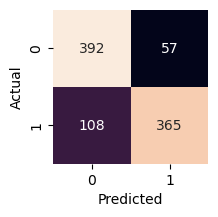

In [62]:
plt.figure(figsize=(2,2))
cf = confusion_matrix(y_train, y_hat)
sns.heatmap(cf, annot=True, fmt='.0f', cbar=False)
plt.ylabel('Actual'), plt.xlabel('Predicted')
plt.show()

In [44]:
cf

array([[392,  57],
       [108, 365]], dtype=int64)

In [39]:
#            left node,  right node
# class_0       302         147
# class_1       150         323
# -------------------------------------
# total         452         470

In [24]:
# proba of each class in each leaf
probas = cf/cf.sum(axis=0)
probas

array([[0.66814159, 0.31276596],
       [0.33185841, 0.68723404]])

In [25]:
# gini impurity of each leaf = 1 - sum(p0^2, p1^2)
# each value power 2, then 1 - their sum
gini_leaf = 1 - np.sum(np.power(probas,2), axis=0)
gini_leaf

array([0.44345681, 0.42988683])

In [26]:
# weighted average (num of observations in each leaf) / total observations
weighted_avg = cf.sum(axis=0) / cf.sum()
weighted_avg

array([0.49023861, 0.50976139])

In [27]:
# node gini = sum of (leaf gini * weighted average)
(gini_leaf*weighted_avg).sum()

0.4365393561678357

In [28]:
# one liner
((1 - np.power(cf / cf.sum(axis=0),2).sum(axis=0)) * cf.sum(axis=0)/cf.sum()).sum()

0.4365393561678356

In [29]:
# function
def gini_node(y_train, y_hat):
    cf = confusion_matrix(y_train, y_hat) + 0.1 # added constant to prevent dividing 0
    return ((1 - np.power(cf / cf.sum(axis=0),2).sum(axis=0)) * cf.sum(axis=0)/cf.sum()).sum()

In [30]:
gini_node(y_train, y_hat)

0.43659432642387175

In [31]:
# gini by feature
def gini_score(feature):
    tree = DecisionTreeClassifier(criterion='gini')
    tree.fit(X_train[[feature]], y_train, sample_weight = df_weights[df_weights.columns[-1]])
    y_hat = tree.predict(X_train[[feature]])
    gini_score = gini_node(y_train, y_hat)
    return gini_score

#### Calculate gini for each feature, return lowest gini feature:

In [32]:
gini_features = pd.DataFrame({
    'features': features,
    'gini': [gini_score(feature) for feature in features]
}).sort_values('gini').reset_index(drop=True)
gini_features

,features,gini
0,chol,0.290797
1,cp,0.366824
2,thal,0.371269
3,thalach,0.376709
4,ca,0.382859
5,oldpeak,0.386015
6,exang,0.404030
7,slope,0.423274
8,age,0.436594
9,trestbps,0.459517


In [33]:
lowest_gini_feature = gini_features.features[0]
lowest_gini_feature

'chol'

In [34]:
def best_feature_from(features):
    gini_features = pd.DataFrame({
    'features': features,
    'gini': [gini_score(feature) for feature in features]
    }).sort_values('gini').reset_index(drop=True)
    return gini_features.features[0]

In [35]:
lowest_gini_feature = best_feature_from(features)
lowest_gini_feature

'chol'

### Step 3. Calculate alpha (amount of say)

In [76]:
def feature_alpha(feature):
    tree = DecisionTreeClassifier(criterion='gini')
    tree.fit(X_train[[feature]], y_train, sample_weight = df_weights[df_weights.columns[-1]])
    y_hat = tree.predict(X_train[[feature]])

    total_error = df_weights[df_weights.columns[-1]][y_train!=y_hat].sum()
    alpha = 0.5 * np.log((1-total_error)/total_error)
    return alpha

In [77]:
lowest_gini_feature

'chol'

In [78]:
alpha = feature_alpha(lowest_gini_feature)
alpha

0.7617088897684342

In [79]:
df_alphas = pd.concat([df_alphas, pd.DataFrame({'feature': [lowest_gini_feature], 'alpha':[alpha]})], ignore_index=True)
df_alphas

,feature,alpha
0,chol,0.761709


### Step 4. Update weight

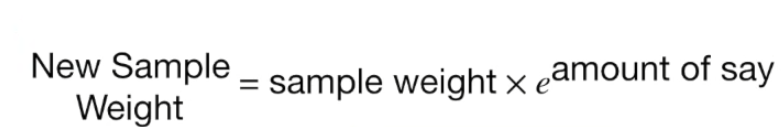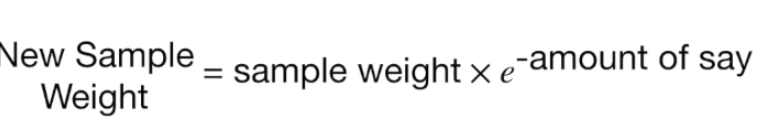

In [80]:
df_weights

,target,init_weights
467,0,0.001085
537,1,0.001085
258,0,0.001085
1017,0,0.001085
152,0,0.001085
...,...,...
137,1,0.001085
300,1,0.001085
430,0,0.001085
507,1,0.001085


In [81]:
def update_weights(lowest_gini_feature):
    df_weights[lowest_gini_feature+'_weights'] = 0
    tree = DecisionTreeClassifier(criterion='gini')
    tree.fit(X_train[[lowest_gini_feature]], y_train, sample_weight = df_weights[df_weights.columns[-2]])
    y_hat = tree.predict(X_train[[lowest_gini_feature]])
    # wrongly classified
    df_weights[df_weights.columns[-1]][y_train!=y_hat] = df_weights[df_weights.columns[-2]][y_train!=y_hat] * np.exp(alpha)

    # correctly classified
    df_weights[df_weights.columns[-1]][y_train==y_hat] = df_weights[df_weights.columns[-2]][y_train==y_hat] * np.exp(-alpha)
    
    # normalize
    df_weights[df_weights.columns[-1]] = (df_weights[df_weights.columns[-1]]/df_weights[df_weights.columns[-1]].sum())

In [82]:
update_weights(lowest_gini_feature)

C:\Users\nguye_5159g\AppData\Local\Temp\ipykernel_24496\3137093861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weights[df_weights.columns[-1]][y_train!=y_hat] = df_weights[df_weights.columns[-2]][y_train!=y_hat] * np.exp(alpha)


In [83]:
df_weights

,target,init_weights,chol_weights
467,0,0.001085,0.000382
537,1,0.001085,0.001752
258,0,0.001085,0.000382
1017,0,0.001085,0.000382
152,0,0.001085,0.000382
...,...,...,...
137,1,0.001085,0.001752
300,1,0.001085,0.001752
430,0,0.001085,0.000382
507,1,0.001085,0.001752


In [84]:
df_weights[df_weights.columns[-1]].sum()

1.0

### Next iteration. Create second decision stump, with updated weights

In [85]:
# drop best features from features
features.remove(lowest_gini_feature)
features

['age',
 'sex',
 'cp',
 'trestbps',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [86]:
lowest_gini_feature = best_feature_from(features)
lowest_gini_feature

'oldpeak'

In [87]:
alpha = feature_alpha(lowest_gini_feature)
alpha

0.9464401715180099

In [88]:
df_alphas = pd.concat([df_alphas, pd.DataFrame({'feature': [lowest_gini_feature], 'alpha':[alpha]})], ignore_index=True)
df_alphas

,feature,alpha
0,chol,0.761709
1,oldpeak,0.946440


### Create third decision stump, with updated weights

In [89]:
# drop best features from features
features.remove(lowest_gini_feature)
features

['age',
 'sex',
 'cp',
 'trestbps',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'slope',
 'ca',
 'thal']

In [90]:
lowest_gini_feature = best_feature_from(features)
lowest_gini_feature

'thalach'

In [91]:
alpha = feature_alpha(lowest_gini_feature)
alpha

0.9567795023260477

In [92]:
df_alphas = pd.concat([df_alphas, pd.DataFrame({'feature': [lowest_gini_feature], 'alpha':[alpha]})], ignore_index=True)
df_alphas

,feature,alpha
0,chol,0.761709
1,oldpeak,0.946440
2,thalach,0.956780


# 3. Combined in functions

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('heart.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df.target, stratify = df.target, test_size=0.3, random_state=14)

In [158]:
# gini impurity for each node
def gini_node(y_train, y_hat):
    cf = confusion_matrix(y_train, y_hat) + 0.1 # added constant to prevent dividing 0
    return ((1 - np.power(cf / cf.sum(axis=0),2).sum(axis=0)) * cf.sum(axis=0)/cf.sum()).sum()

In [159]:
# gini impurity by feature
def gini_score(X_sampled, y_sampled, feature, df_weights):
    tree = DecisionTreeClassifier(criterion='gini', random_state=1)
    tree.fit(X_sampled[[feature]], y_sampled, sample_weight = df_weights[df_weights.columns[-1]])
    y_hat = tree.predict(X_sampled[[feature]])
    gini_impurity = gini_node(y_sampled, y_hat)
    return gini_impurity

In [160]:
# select the best feature (lowest gini impurity) for each iteration
def best_feature_from(X_sampled, y_sampled, features, df_weights):
    gini_features = pd.DataFrame({
    'features': features,
    'gini': [gini_score(X_sampled, y_sampled, feature, df_weights) for feature in features]
    }).sort_values('gini').reset_index(drop=True)
    return gini_features.features[0]

In [161]:
# calculate alpha
def feature_alpha(X_sampled, y_sampled, feature, df_weights):
    tree = DecisionTreeClassifier(criterion='gini', random_state=1)
    tree.fit(X_sampled[[feature]], y_sampled, sample_weight = df_weights[df_weights.columns[-1]])
    y_hat = tree.predict(X_sampled[[feature]])
    
    y_wrong_index = y_sampled[y_sampled!=y_hat].index
    total_error = df_weights[df_weights.columns[-1]][y_wrong_index].sum()
    alpha = 0.5 * np.log((1-total_error)/total_error)
    return alpha, tree, y_hat

In [162]:
# update weights
def update_weights(y_hat, y_sampled, iteration_th, lowest_gini_feature, df_weights, alpha):
    df_weights['iter_'+str(iteration_th)+'_weights'] = df_weights[df_weights.columns[-1]]
    # tree = DecisionTreeClassifier(criterion='gini', random_state=1)
    # careful at this. use weights from 2 previous features
    # later can specify the specific column weight? by storing the previous lowest_gini_feature feature before calculate new one
    # tree.fit(X_sampled[[lowest_gini_feature]], y_sampled, sample_weight = df_weights[df_weights.columns[-2]])
    # y_hat = tree.predict(X_sampled[[lowest_gini_feature]])
    
    # wrongly classified
    wrong_classified_index = y_sampled[y_sampled!=y_hat].index
    df_weights[df_weights.columns[-1]][wrong_classified_index] = df_weights[df_weights.columns[-2]][wrong_classified_index] * np.exp(alpha)

    # correctly classified
    correct_classified_index = y_sampled[y_sampled==y_hat].index
    df_weights[df_weights.columns[-1]][correct_classified_index] = df_weights[df_weights.columns[-2]][correct_classified_index] * np.exp(-alpha)

    # normalize
    df_weights[df_weights.columns[-1]] = (df_weights[df_weights.columns[-1]]/df_weights[df_weights.columns[-1]].sum())

### Loops

In [154]:
def ada_fit(X_train, y_train, iters, init_random_state=3):
    # reset features
    features = X_train.columns.tolist()
    
    # add initial weights
    df_weights = pd.DataFrame({'target': y_train})
    df_weights['init_weights'] = 1/len(y_train)

    df_alphas = pd.DataFrame()
    
    # assign original X_sampled, y_sampled
    Xy_train = pd.concat([X_train, y_train], axis=1)
    X_sampled = X_train
    y_sampled = y_train
    
    for iteration_th in np.arange(1, iters+1,1):
        # first step
        lowest_gini_feature = best_feature_from(X_sampled, y_sampled, features, df_weights)

        # alpha
        alpha, tree, y_hat = feature_alpha(X_sampled, y_sampled, lowest_gini_feature, df_weights)

        # update alpha
        df_alphas = pd.concat([df_alphas, pd.DataFrame({'feature': [lowest_gini_feature], 'alpha':[alpha], 'tree':[tree]})], ignore_index=True)
          
        # update weights
        update_weights(y_hat, y_sampled, iteration_th, lowest_gini_feature, df_weights, alpha)

        # reassigned the X_sampled, y_sampled 
        Xy_sampled = Xy_train.sample(n=len(Xy_train), weights=df_weights[df_weights.columns[-1]], replace=True, random_state=init_random_state+iteration_th*2)
        X_sampled = Xy_sampled.drop(columns='target')
        y_sampled = Xy_sampled['target']
    
    # normalize alpha score
    df_alphas.alpha = (df_alphas.alpha - df_alphas.alpha.min())  /  (df_alphas.alpha.max() - df_alphas.alpha.min())
    return df_alphas

In [155]:
def ada_predict(X_train, y_train, df_alphas, show_weights = False):
    df_preds = pd.DataFrame()
    # store prediction by each weak learner
    for i, row in df_alphas.iterrows():
        y_hat = row.tree.predict(X_train[[row.feature]])
        # store prediction of each learner
        df_preds[row.feature+'_' + str(i)] = y_hat
        # convert 0 -> -1
        df_preds[row.feature+'_' + str(i)][df_preds[row.feature+'_' + str(i)]==0] = -1
        # multiply by alpha -> amount of say
        df_preds[row.feature+'_' + str(i)] = df_preds[row.feature+'_' + str(i)]*row.alpha
    # make weighted prediction
    df_preds['weighted_prediction'] = df_preds.sum(axis=1)
    # weighted predictions to final prediction
    df_preds['final_prediction'] = df_preds['weighted_prediction'].apply(lambda x: 1 if x>0 else 0)
    
    # return final predictions
    if show_weights:
        return df_preds
    else:
        return df_preds.final_prediction

#### Test run

In [156]:
alphas = ada_fit(X_train, y_train, 50, init_random_state=1) #1,2
alphas.head()

,feature,alpha,tree
0,chol,0.859767,DecisionTreeClassifier(random_state=1)
1,chol,1.000000,DecisionTreeClassifier(random_state=1)
2,chol,0.552943,DecisionTreeClassifier(random_state=1)
3,thalach,0.549676,DecisionTreeClassifier(random_state=1)
4,oldpeak,0.362845,DecisionTreeClassifier(random_state=1)


Accuracy train: 0.8968
Accuracy test: 0.8864


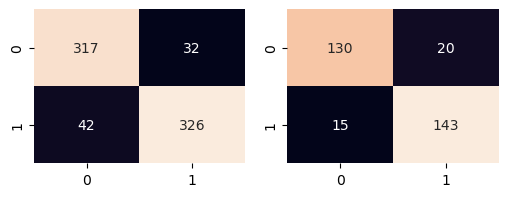

In [157]:
yhat_train = ada_predict(X_train, y_train, alphas)
yhat_test = ada_predict(X_test, y_test, alphas)

print(f'Accuracy train: {accuracy_score(y_train, yhat_train):.4f}')
print(f'Accuracy test: {accuracy_score(y_test, yhat_test):.4f}')

fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(6,2))
sns.heatmap(confusion_matrix(y_train, yhat_train), annot=True, cbar=False, fmt='.0f', ax=ax1)
sns.heatmap(confusion_matrix(y_test, yhat_test), annot=True, cbar=False, fmt='.0f', ax=ax2)
plt.show()

#### Prepare

In [9]:
# reset features
features = X_train.columns.tolist()

# add initial weights
df_weights = pd.DataFrame({'target': y_train})
df_weights['iter_0_weights'] = 1/len(y_train)

df_alphas = pd.DataFrame()

In [10]:
# assign original X_sampled, y_sampled
X_sampled = X_train
y_sampled = y_train

#### Iteration 1

In [11]:
lowest_gini_feature = best_feature_from(X_sampled, y_sampled, features, df_weights)
lowest_gini_feature

'chol'

In [12]:
# alpha
alpha = feature_alpha(X_sampled, y_sampled, lowest_gini_feature, df_weights)
alpha

1.2211735176846021

In [13]:
# update alpha
df_alphas = pd.concat([df_alphas, pd.DataFrame({'feature': [lowest_gini_feature], 'alpha':[alpha]})], ignore_index=True)
df_alphas

,feature,alpha
0,chol,1.221174


In [14]:
iteration_th = 1

# create new place holder weight, copy from previous weights
df_weights['iter_'+str(iteration_th)+'_weights'] = df_weights[df_weights.columns[-1]]
df_weights

,target,iter_0_weights,iter_1_weights
972,1,0.01,0.01
697,0,0.01,0.01
110,0,0.01,0.01
158,1,0.01,0.01
107,0,0.01,0.01
...,...,...,...
838,1,0.01,0.01
129,1,0.01,0.01
1009,0,0.01,0.01
798,0,0.01,0.01


In [15]:
tree = DecisionTreeClassifier(criterion='gini', random_state=1)
# careful at this. use weights from 2 previous column

tree.fit(X_sampled[[lowest_gini_feature]], y_sampled, sample_weight = df_weights[df_weights.columns[-2]])
y_hat = tree.predict(X_sampled[[lowest_gini_feature]])

In [16]:
y_hat

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

In [17]:
X_sampled

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
972,52,1,3,118,186,0,0,190,0,0.0,1,0,1
697,67,1,2,152,212,0,0,150,0,0.8,1,0,3
110,44,1,0,110,197,0,0,177,0,0.0,2,1,2
158,67,0,2,115,564,0,0,160,0,1.6,1,0,3
107,62,1,1,120,281,0,0,103,0,1.4,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,51,1,3,125,213,0,0,125,1,1.4,2,1,2
129,57,1,0,140,192,0,1,148,0,0.4,1,0,1
1009,40,1,0,152,223,0,1,181,0,0.0,2,0,3
798,59,1,3,170,288,0,0,159,0,0.2,1,0,3


In [18]:



# wrongly classified
df_weights[df_weights.columns[-1]][y_sampled!=y_hat] = df_weights[df_weights.columns[-2]][y_sampled!=y_hat] * np.exp(alpha)

# correctly classified
df_weights[df_weights.columns[-1]][y_sampled==y_hat] = df_weights[df_weights.columns[-2]][y_sampled==y_hat] * np.exp(-alpha)

# normalize
df_weights[df_weights.columns[-1]] = (df_weights[df_weights.columns[-1]]/df_weights[df_weights.columns[-1]].sum())

In [19]:
df_weights.iter_1_weights.value_counts()

0.005435    92
0.062500     8
Name: iter_1_weights, dtype: int64

In [20]:
# where are the wrong values
df_weights[df_weights.iter_1_weights>0.06]

,target,iter_0_weights,iter_1_weights
529,1,0.01,0.0625
955,1,0.01,0.0625
761,1,0.01,0.0625
528,1,0.01,0.0625
949,1,0.01,0.0625
956,1,0.01,0.0625
320,1,0.01,0.0625
240,1,0.01,0.0625


In [21]:
df_weights

,target,iter_0_weights,iter_1_weights
972,1,0.01,0.005435
697,0,0.01,0.005435
110,0,0.01,0.005435
158,1,0.01,0.005435
107,0,0.01,0.005435
...,...,...,...
838,1,0.01,0.005435
129,1,0.01,0.005435
1009,0,0.01,0.005435
798,0,0.01,0.005435


In [22]:
### resample

# concat x,y
Xy = pd.concat([X_sampled, y_sampled], axis=1)
Xy

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
972,52,1,3,118,186,0,0,190,0,0.0,1,0,1,1
697,67,1,2,152,212,0,0,150,0,0.8,1,0,3,0
110,44,1,0,110,197,0,0,177,0,0.0,2,1,2,0
158,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1
107,62,1,1,120,281,0,0,103,0,1.4,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,51,1,3,125,213,0,0,125,1,1.4,2,1,2,1
129,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
1009,40,1,0,152,223,0,1,181,0,0.0,2,0,3,0
798,59,1,3,170,288,0,0,159,0,0.2,1,0,3,0


In [23]:
# sampled from Xy

Xy_sampled = Xy.sample(n=len(Xy), weights=df_weights[df_weights.columns[-1]], replace=True)
X_sampled = Xy_sampled.drop(columns='target')
y_sampled = Xy_sampled.target

Xy_sampled

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
596,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
233,41,0,1,126,306,0,1,163,0,0.0,2,0,2,1
761,49,0,0,130,269,0,1,163,0,0.0,2,0,2,1
528,59,1,3,178,270,0,0,145,0,4.2,0,0,3,1
712,45,0,1,112,160,0,1,138,0,0.0,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,69,1,3,160,234,1,0,131,0,0.1,1,1,2,1
554,58,1,0,100,234,0,1,156,0,0.1,2,1,3,0
25,61,0,0,145,307,0,0,146,1,1.0,1,0,3,0
761,49,0,0,130,269,0,1,163,0,0.0,2,0,2,1


#### iteration 2

In [25]:
lowest_gini_feature = best_feature_from(X_sampled, y_sampled, features, df_weights)
lowest_gini_feature

'chol'

In [26]:
def feature_alpha(X_sampled, y_sampled, feature, df_weights):
    tree = DecisionTreeClassifier(criterion='gini', random_state=1)
    tree.fit(X_sampled[[feature]], y_sampled, sample_weight = df_weights[df_weights.columns[-1]])
    y_hat = tree.predict(X_sampled[[feature]])
    
    y_wrong_index = y_sampled[y_sampled!=y_hat].index
    total_error = df_weights[df_weights.columns[-1]][y_wrong_index].sum()
    alpha = 0.5 * np.log((1-total_error)/total_error)
    return alpha

In [27]:
# alpha
alpha = feature_alpha(X_sampled, y_sampled, lowest_gini_feature, df_weights)
alpha

2.049942371298858

In [28]:
# update alpha
df_alphas = pd.concat([df_alphas, pd.DataFrame({'feature': [lowest_gini_feature], 'alpha':[alpha]})], ignore_index=True)
df_alphas

,feature,alpha
0,chol,1.221174
1,chol,2.049942


In [29]:
iteration_th = 2

# create new place holder weight, copy from previous weights
df_weights['iter_'+str(iteration_th)+'_weights'] = df_weights[df_weights.columns[-1]]
df_weights

,target,iter_0_weights,iter_1_weights,iter_2_weights
972,1,0.01,0.005435,0.005435
697,0,0.01,0.005435,0.005435
110,0,0.01,0.005435,0.005435
158,1,0.01,0.005435,0.005435
107,0,0.01,0.005435,0.005435
...,...,...,...,...
838,1,0.01,0.005435,0.005435
129,1,0.01,0.005435,0.005435
1009,0,0.01,0.005435,0.005435
798,0,0.01,0.005435,0.005435


In [31]:
tree = DecisionTreeClassifier(criterion='gini', random_state=1)
# careful at this. use weights from 2 previous column

tree.fit(X_sampled[[lowest_gini_feature]], y_sampled, sample_weight = df_weights[df_weights.columns[-2]])
y_hat = tree.predict(X_sampled[[lowest_gini_feature]])

In [33]:
# wrongly classified
wrong_classified_index = y_sampled[y_sampled!=y_hat].index
df_weights[df_weights.columns[-1]][wrong_classified_index] = df_weights[df_weights.columns[-2]][wrong_classified_index] * np.exp(alpha)

# correctly classified
correct_classified_index = y_sampled[y_sampled==y_hat].index

df_weights[df_weights.columns[-1]][correct_classified_index] = df_weights[df_weights.columns[-2]][correct_classified_index] * np.exp(-alpha)

# normalize
df_weights[df_weights.columns[-1]] = (df_weights[df_weights.columns[-1]]/df_weights[df_weights.columns[-1]].sum())

In [36]:
df_weights.iter_2_weights.value_counts()

0.011745    53
0.001512    37
0.017389     8
0.091229     2
Name: iter_2_weights, dtype: int64

In [37]:
df_weights.iter_2_weights[df_weights.iter_2_weights>0.09]

554    0.091229
798    0.091229
Name: iter_2_weights, dtype: float64

In [38]:
# sampled from Xy

Xy_sampled = Xy.sample(n=len(Xy), weights=df_weights[df_weights.columns[-1]], replace=True)

Xy_sampled

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
897,52,1,1,134,201,0,1,158,0,0.8,2,1,2,1
969,52,1,1,120,325,0,1,172,0,0.2,2,0,2,1
291,58,1,0,128,259,0,0,130,1,3.0,1,2,3,0
956,49,0,0,130,269,0,1,163,0,0.0,2,0,2,1
145,40,1,0,110,167,0,0,114,1,2.0,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,58,1,0,146,218,0,1,105,0,2.0,1,1,3,0
798,59,1,3,170,288,0,0,159,0,0.2,1,0,3,0
949,57,1,0,132,207,0,1,168,1,0.0,2,0,3,1
554,58,1,0,100,234,0,1,156,0,0.1,2,1,3,0


In [39]:
X_sampled = Xy_sampled.drop(columns='target')
y_sampled = Xy_sampled.target

#### iteration 3

In [40]:
lowest_gini_feature = best_feature_from(X_sampled, y_sampled, features, df_weights)
lowest_gini_feature

'thalach'

In [41]:
def feature_alpha(X_sampled, y_sampled, feature, df_weights):
    tree = DecisionTreeClassifier(criterion='gini', random_state=1)
    tree.fit(X_sampled[[feature]], y_sampled, sample_weight = df_weights[df_weights.columns[-1]])
    y_hat = tree.predict(X_sampled[[feature]])
    
    y_wrong_index = y_sampled[y_sampled!=y_hat].index
    total_error = df_weights[df_weights.columns[-1]][y_wrong_index].sum()
    alpha = 0.5 * np.log((1-total_error)/total_error)
    return alpha

In [42]:
# alpha
alpha = feature_alpha(X_sampled, y_sampled, lowest_gini_feature, df_weights)
alpha

1.4157261687785112

In [43]:
# update alpha
df_alphas = pd.concat([df_alphas, pd.DataFrame({'feature': [lowest_gini_feature], 'alpha':[alpha]})], ignore_index=True)
df_alphas

,feature,alpha
0,chol,1.221174
1,chol,2.049942
2,thalach,1.415726


In [44]:
iteration_th = 3

# create new place holder weight, copy from previous weights
df_weights['iter_'+str(iteration_th)+'_weights'] = df_weights[df_weights.columns[-1]]
df_weights

,target,iter_0_weights,iter_1_weights,iter_2_weights,iter_3_weights
972,1,0.01,0.005435,0.001512,0.001512
697,0,0.01,0.005435,0.001512,0.001512
110,0,0.01,0.005435,0.011745,0.011745
158,1,0.01,0.005435,0.011745,0.011745
107,0,0.01,0.005435,0.001512,0.001512
...,...,...,...,...,...
838,1,0.01,0.005435,0.011745,0.011745
129,1,0.01,0.005435,0.001512,0.001512
1009,0,0.01,0.005435,0.011745,0.011745
798,0,0.01,0.005435,0.091229,0.091229


In [45]:
tree = DecisionTreeClassifier(criterion='gini', random_state=1)
# careful at this. use weights from 2 previous column

tree.fit(X_sampled[[lowest_gini_feature]], y_sampled, sample_weight = df_weights[df_weights.columns[-2]])
y_hat = tree.predict(X_sampled[[lowest_gini_feature]])

In [46]:
# wrongly classified
wrong_classified_index = y_sampled[y_sampled!=y_hat].index
df_weights[df_weights.columns[-1]][wrong_classified_index] = df_weights[df_weights.columns[-2]][wrong_classified_index] * np.exp(alpha)

# correctly classified
correct_classified_index = y_sampled[y_sampled==y_hat].index

df_weights[df_weights.columns[-1]][correct_classified_index] = df_weights[df_weights.columns[-2]][correct_classified_index] * np.exp(-alpha)

# normalize
df_weights[df_weights.columns[-1]] = (df_weights[df_weights.columns[-1]]/df_weights[df_weights.columns[-1]].sum())

In [47]:
df_weights.iter_3_weights.value_counts()

0.002233    32
0.004210    31
0.017342    19
0.006233     6
0.000542     3
0.071438     3
0.009197     2
0.032698     2
0.025675     1
0.105767     1
Name: iter_3_weights, dtype: int64

In [50]:
df_weights.iter_3_weights[df_weights.iter_3_weights>0.03]

879    0.071438
554    0.032698
731    0.071438
240    0.105767
798    0.032698
291    0.071438
Name: iter_3_weights, dtype: float64

In [51]:
# sampled from Xy

Xy_sampled = Xy.sample(n=len(Xy), weights=df_weights[df_weights.columns[-1]], replace=True)

Xy_sampled

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
307,44,1,1,120,220,0,1,170,0,0.0,2,0,2,1
404,61,1,0,140,207,0,0,138,1,1.9,2,1,3,0
795,62,1,1,128,208,1,0,140,0,0.0,2,0,2,1
291,58,1,0,128,259,0,0,130,1,3.0,1,2,3,0
795,62,1,1,128,208,1,0,140,0,0.0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
277,44,1,1,130,219,0,0,188,0,0.0,2,0,2,1
667,57,1,1,124,261,0,1,141,0,0.3,2,0,3,0
240,54,0,1,132,288,1,0,159,1,0.0,2,1,2,1


In [52]:
X_sampled = Xy_sampled.drop(columns='target')
y_sampled = Xy_sampled.target

# 4. Compare with sklearn AdaBoostClassifier

In [18]:
from sklearn.ensemble import AdaBoostClassifier

Accuracy train: 0.8884
Accuracy test: 0.8442


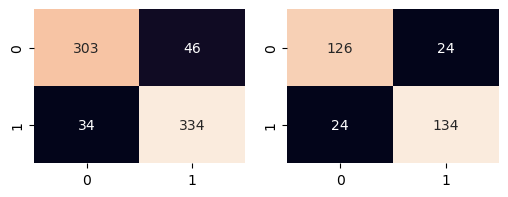

In [19]:
ada = AdaBoostClassifier(algorithm = 'SAMME', random_state=1)
ada.fit(X_train, y_train)
yhat_train = ada.predict(X_train)
yhat_test = ada.predict(X_test)

print(f'Accuracy train: {accuracy_score(y_train, yhat_train):.4f}')
print(f'Accuracy test: {accuracy_score(y_test, yhat_test):.4f}')

fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(6,2))
sns.heatmap(confusion_matrix(y_train, yhat_train), annot=True, cbar=False, fmt='.0f', ax=ax1)
sns.heatmap(confusion_matrix(y_test, yhat_test), annot=True, cbar=False, fmt='.0f', ax=ax2)
plt.show()

Accuracy train: 0.9247
Accuracy test: 0.8961


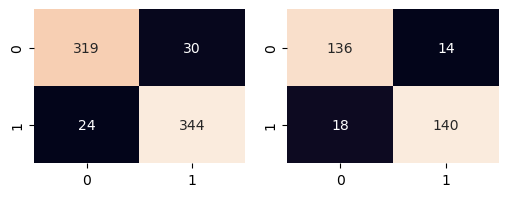

In [20]:
ada = AdaBoostClassifier(algorithm = 'SAMME.R', random_state=1, n_estimators = 50)
ada.fit(X_train, y_train)
yhat_train = ada.predict(X_train)
yhat_test = ada.predict(X_test)

print(f'Accuracy train: {accuracy_score(y_train, yhat_train):.4f}')
print(f'Accuracy test: {accuracy_score(y_test, yhat_test):.4f}')

fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(6,2))
sns.heatmap(confusion_matrix(y_train, yhat_train), annot=True, cbar=False, fmt='.0f', ax=ax1)
sns.heatmap(confusion_matrix(y_test, yhat_test), annot=True, cbar=False, fmt='.0f', ax=ax2)
plt.show()